# Preprocessing of USPTO (Reaxys formatted)

In [1]:
import pandas as pd
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
import numpy as np
from tqdm import tqdm
from tqdm import trange
# import pyarrow as pa

In [2]:
"""
Disables RDKit whiny logging.
"""
import rdkit.rdBase as rkrb
import rdkit.RDLogger as rkl
logger = rkl.logger()
logger.setLevel(rkl.ERROR)
rkrb.DisableLog('rdApp.error')


In [3]:
USPTO_elsevier = pd.read_csv('data/USPTO_from_reaxys/uspto_1k_TPL_train_valid.tsv', sep='\t')
USPTO_elsevier.columns

Index(['Unnamed: 0', 'level_0', 'index', 'original_rxn', 'fragments', 'source',
       'year', 'mapped_rxn', 'confidence', 'canonical_rxn_with_fragment_info',
       'canonical_rxn', 'ID', 'reaction_hash', 'reactants', 'products',
       'retro_template', 'template_hash', 'selectivity', 'outcomes',
       'reagents', 'labels'],
      dtype='object')

In [4]:
# USPTO_elsevier = USPTO_elsevier.iloc[:200000]

In [5]:
# create lists for reactants and other stuff
reactant1_list = []
reactant2_list = []

product_list = [] #there's only ever 1 product

reagent1_list = []
reagent2_list = []

other_list = []

for i in range(len(USPTO_elsevier)):
    #handle reactants first
    reactant1 = None
    reactant2 = None
    other = []
    reactants = USPTO_elsevier['reactants'][i].split('.')
    for molecule in reactants:
        if '[' in molecule: #its a reactant
            if not reactant1:
                reactant1 = molecule
            elif not reactant2:
                reactant2 = molecule
            else:
                other +=[molecule]
        else:
            other +=[molecule]

    #then reagents
    reagent1 = None
    reagent2 = None
    reagents = USPTO_elsevier['reagents'][i]
    if reagents == reagents:
        reagents = reagents.split('.')
        for molecule in reagents:
            #populate the first two variables with reagents, add everything else to 'other'
            if 'Pd' in molecule:
                other += [molecule]
            else: 
                if not reagent1:
                    reagent1 = molecule
                elif not reagent2:
                    reagent2 = molecule
                else:
                    other +=[molecule]

    reactant1_list += [reactant1]
    reactant2_list += [reactant2]
    product_list += [USPTO_elsevier['products'][i]]
    reagent1_list += [reagent1]
    reagent2_list += [reagent2]
    other_list += [other]
del USPTO_elsevier

# Read in USPTO data from ORD format (pickled data)

In [6]:
from os import listdir
from os.path import isfile, join
import pandas as pd
from tqdm import tqdm

In [7]:
# mypath = 'data/ORD_USPTO/pickled_data/'
# onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [8]:
# #create one big df of all the pickled data
# full_df = pd.DataFrame()
# for file in tqdm(onlyfiles):
#     if file[0] != '.': #We don't want to try to unpickle .DS_Store
#         filepath = mypath+file 
#         unpickled_df = pd.read_pickle(filepath)
#         full_df = pd.concat([full_df, unpickled_df], ignore_index=True)


In [9]:
# full_df

# Calculate FP

In [10]:
def calc_fp(lst, radius, nBits):
    ans = []
    for i in tqdm(lst):
        #convert to mole object
        try:
            mol = Chem.MolFromSmiles(i)
            fp = AllChem.GetHashedMorganFingerprint(mol, radius, nBits=nBits)
            array = np.zeros((0,), dtype=np.int8)
            DataStructs.ConvertToNumpyArray(fp, array)
            ans += [array]
        except:
            ans += [np.zeros((nBits,), dtype=int)]
    return ans

In [11]:
# calculate fingerprints
radius = 3
nBits = 1024

In [12]:
reactant1_list_fp = calc_fp(reactant1_list, radius, nBits)

100%|██████████| 400604/400604 [01:25<00:00, 4660.80it/s]


In [13]:
from collections import Counter
counter_obj = Counter(reactant1_list)

In [14]:
allowed_reactants = {k:v for k,v in counter_obj.items() if v > 10}
allowed_reactants = list(allowed_reactants.keys())

In [15]:
allowed_idxes = [idx for idx, i in enumerate(reactant1_list) if i in allowed_reactants]
# takes roughly 3 mins 30

In [16]:
reactant2_list_fp = calc_fp(reactant2_list, radius, nBits)

100%|██████████| 400604/400604 [00:57<00:00, 6972.34it/s]


In [17]:
product_list_fp = calc_fp(product_list, radius, nBits)

100%|██████████| 400604/400604 [02:07<00:00, 3153.93it/s]


In [18]:
#don't actually need to create a fp of the reagent
reagent1_list_fp = calc_fp(reagent1_list, radius, nBits)

100%|██████████| 400604/400604 [00:35<00:00, 11234.80it/s]


In [19]:
#don't actually need to create a fp of the reagent
reagent2_list_fp = calc_fp(reagent2_list, radius, nBits)

100%|██████████| 400604/400604 [00:29<00:00, 13418.10it/s]


In [20]:
# convert to arrays
p = np.array(product_list_fp)[allowed_idxes]
r1 = np.array(reactant1_list_fp)[allowed_idxes]
r2 = np.array(reactant2_list_fp)[allowed_idxes]
rea1 = np.array(reagent1_list_fp)[allowed_idxes]
rea2 = np.array(reagent2_list_fp)[allowed_idxes]
del product_list_fp, reactant1_list_fp, reactant2_list_fp, reagent1_list_fp, reagent2_list_fp

In [21]:
# calculate rxn difference fp
rxn_diff_fp = p - r1 - r2

In [22]:
rxn_diff_fp.shape

(132735, 1024)

In [23]:
np.min(np.sum(np.abs(rxn_diff_fp),axis=1))

11

# Clustering

In [24]:
# https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1
# let's use sklearn KMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
%matplotlib inline

# NN modelling

In [25]:
import torch
import torchmetrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

C:\Users\Joe_Aspect\miniconda3\envs\cps-env\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


In [26]:
# create one-hot encoding of reagent1_list

#start by canonicalising all the reagents
reag1  = []
for idx, smiles in tqdm(enumerate(reagent1_list)):
    if idx not in allowed_idxes:
        continue
    try:
        canon_smiles = Chem.MolToSmiles(Chem.MolFromSmiles(smiles))
        reag1 += [canon_smiles]
    except TypeError:
        reag1 += [np.nan]
print(len(set(reag1)))
reag1 = np.array(reag1)

400604it [07:02, 947.65it/s] 


1187


In [27]:
# create one-hot encoding of reagent1_list

#start by canonicalising all the reagents
reag2  = []
for idx, smiles in tqdm(enumerate(reagent2_list)):
    if idx not in allowed_idxes:
        continue
    try:
        canon_smiles = Chem.MolToSmiles(Chem.MolFromSmiles(smiles))
        reag2 += [canon_smiles]
    except TypeError:
        reag2 += [np.nan]
print(len(set(reag2)))
reag2 = np.array(reag1)

400604it [07:08, 934.91it/s] 

1099


In [38]:
reags = np.concatenate([reag1, reag2], axis=0)
# Now do the one-hot encoding
enc = OneHotEncoder(handle_unknown='ignore')
reag_reshaped = reags.reshape(-1, 1)
_ = enc.fit(reag_reshaped)

In [29]:
reag1_ohe = enc.transform(reag1.reshape(-1, 1)).toarray()
reag2_ohe = enc.transform(reag2.reshape(-1, 1)).toarray()

## Fully connected

In [30]:
rxn_diff_fp_train, rxn_diff_fp_val, reag1_ohe_train, reag1_ohe_val = train_test_split(rxn_diff_fp, reag1_ohe, test_size=0.2, random_state=42)

In [31]:
rxn_diff_fp_train.shape

(106188, 1024)

In [32]:
Kmean = KMeans(n_clusters=5, verbose=1, max_iter=50, random_state=42)
_ = Kmean.fit(rxn_diff_fp_train)

Initialization complete
Iteration 0, inertia 16178064.0.
Iteration 1, inertia 10631820.72104479.
Iteration 2, inertia 10347386.413162023.
Iteration 3, inertia 10222251.837299928.
Iteration 4, inertia 10166882.601709995.
Iteration 5, inertia 10130821.195507666.
Iteration 6, inertia 10102928.96985754.
Iteration 7, inertia 10075160.417406289.
Iteration 8, inertia 10034830.443321655.
Iteration 9, inertia 9994791.255437663.
Iteration 10, inertia 9969403.401320398.
Iteration 11, inertia 9953464.201548256.
Iteration 12, inertia 9918261.807112353.
Iteration 13, inertia 9827079.558154745.
Iteration 14, inertia 9712064.214222707.
Iteration 15, inertia 9666499.286480881.
Iteration 16, inertia 9650788.01219916.
Iteration 17, inertia 9638883.11378271.
Iteration 18, inertia 9629337.325867929.
Iteration 19, inertia 9625147.29259964.
Iteration 20, inertia 9623746.326649446.
Iteration 21, inertia 9623240.660046699.
Iteration 22, inertia 9623067.912866578.
Iteration 23, inertia 9623017.290303636.
Iterat

In [33]:
train_clusters = Kmean.predict(rxn_diff_fp_train)

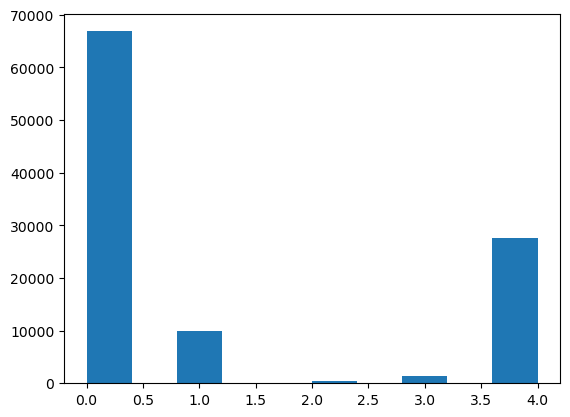

In [34]:
_ = plt.hist(train_clusters)

In [35]:
f"num classes = {reag1_ohe_train.shape[1]}"

'num classes = 1187'

In [73]:
class FullyConnectedReactionModel(torch.nn.Module):

    def __init__(
        self, 
        *, 
        input_dim, 
        hidden_dims, 
        target_dim,
        hidden_act, 
        output_act, 
        use_batchnorm, 
        dropout_prob
    ):
        super(FullyConnectedReactionModel, self).__init__()
        layers = []
        prev_dim = input_dim
        for dim in hidden_dims:
            layers.append(torch.nn.Linear(prev_dim, dim))
            layers.append(hidden_act())
            if use_batchnorm:
                layers.append(torch.nn.BatchNorm1d(dim))
            if dropout_prob > 0:
                layers.append(torch.nn.Dropout(p=0.2))
            prev_dim = dim
        layers.append(torch.nn.Linear(prev_dim, target_dim))
        if output_act is torch.nn.Softmax:
            layers.append(output_act(dim=1))
        else:
            layers.append(output_act())
        self.layers = torch.nn.Sequential(*layers)

    def forward(self, x, training=True):

        if training:
            self.train()
        else:
            self.eval()

        return self.layers(x)



def train_loop(model, x_train, y_train, *, epochs, batch_size, loss_fn, optimizer, report_freq, train_cluster_ids_for_downstream=None, train_similarity_dist=None, x_val=None, y_val=None, val_cluster_ids_for_downstream=None, val_similarity_dist=None):
    
    report_epochs = []
    train_loss_trajectory = []
    val_loss_trajectory = []
    train_acc_trajectory = []
    val_acc_trajectory = []
    train_acc_trajectory_top5 = []
    val_acc_trajectory_top5 = []
    train_acc_trajectory_top3 = []
    val_acc_trajectory_top3 = []

    if report_freq and (x_val is not None) and (y_val is not None):
        # if we are reporting the validation data should exist
        if train_cluster_ids_for_downstream is not None:
            assert val_cluster_ids_for_downstream is not None

        if train_similarity_dist is not None:
            assert val_similarity_dist is not None

    acc_metric_top1 = torchmetrics.Accuracy(task="multiclass", num_classes=y_train.shape[1], top_k=1)
    acc_metric_top3 = torchmetrics.Accuracy(task="multiclass", num_classes=y_train.shape[1], top_k=3)
    acc_metric_top5 = torchmetrics.Accuracy(task="multiclass", num_classes=y_train.shape[1], top_k=5)

    # for e in (t := trange(epochs, desc='', leave=True)):
    for e in range(epochs):
        idxes = np.arange(x_train.shape[0])
        np.random.shuffle(idxes)

        prev_idx = 0
        interval = int(idxes.shape[0] * batch_size)

        epoch_train_acc = []
        epoch_train_acc_top3 = []
        epoch_train_acc_top5 = []

        for idx in tqdm(range(interval, idxes.shape[0]+1, interval)):
            if batch_size < 1.0:
                batch_idxes = idxes[prev_idx:idx]
            else:
                batch_idxes = idxes
            prev_idx = idx

            if train_cluster_ids_for_downstream is None:
                pred_train = model(x_train[batch_idxes], training=True)
            else:
                pred_train = model(x_train[batch_idxes], train_cluster_ids_for_downstream[batch_idxes], training=True)
            if train_similarity_dist == None:
                loss = loss_fn(pred_train, y_train[batch_idxes])
            else:
                loss = loss_fn(pred_train, y_train[batch_idxes], train_similarity_dist[batch_idxes])
            
            epoch_train_acc.append(acc_metric_top1(pred_train, y_train[batch_idxes].argmax(axis=1)).item())
            epoch_train_acc_top3.append(acc_metric_top3(pred_train, y_train[batch_idxes].argmax(axis=1)).item())
            epoch_train_acc_top5.append(acc_metric_top5(pred_train, y_train[batch_idxes].argmax(axis=1)).item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_acc_trajectory.append(np.mean(epoch_train_acc))
        train_acc_trajectory_top3.append(np.mean(epoch_train_acc_top3))
        train_acc_trajectory_top5.append(np.mean(epoch_train_acc_top5))
        
        if report_freq:
            if e % report_freq == 0:
                verbose_str = f"Epoch: {e} Train [ Loss: {loss.detach().numpy().item():.5f} | Acc (Top 1): {train_acc_trajectory[-1]:.5f} | Acc (Top 3): {train_acc_trajectory_top3[-1]:.5f} | Acc (Top 5): {train_acc_trajectory_top5[-1]:.5f}]"
                report_epochs.append(e)
                train_loss_trajectory.append(loss.detach().numpy().item())

                if (x_val is not None) and (y_val is not None):
                    with torch.no_grad():
                        if val_cluster_ids_for_downstream is None:
                            pred_val = model(x_val, training=False)
                        else:
                            pred_val = model(x_val, val_cluster_ids_for_downstream, training=False)
                        if val_similarity_dist == None:
                            loss_val = loss_fn(pred_val, y_val)
                        else:
                            loss_val = loss_fn(pred_val, y_val, val_similarity_dist)

                        val_loss_trajectory.append(loss_val.detach().numpy().item())
                        val_acc = acc_metric_top1(pred_val, y_val.argmax(axis=1)).item()
                        val_acc_trajectory.append(val_acc)
                        val_acc_top5 = acc_metric_top5(pred_val, y_val.argmax(axis=1)).item()
                        val_acc_trajectory_top5.append(val_acc_top5)
                        val_acc_top3 = acc_metric_top3(pred_val, y_val.argmax(axis=1)).item()
                        val_acc_trajectory_top3.append(val_acc_top3)
                        verbose_str += f"\t Validation [ Loss: {loss_val.detach().numpy().item():.5f} | Acc (Top 1): {val_acc:.5f} | Acc (Top 3): {val_acc_top3:.5f} | Acc (Top 5): {val_acc_top5: .5f}]"
                print(verbose_str)
                # t.set_description(verbose_str, refresh=True)

    train_traj = {
        ("train","loss"): train_loss_trajectory, ("train","acc"): train_acc_trajectory,  ("train","acc_top3"): train_acc_trajectory_top3, ("train","acc_top5"): train_acc_trajectory_top5
    }

    if val_loss_trajectory:
        val_traj = {
            ("val","loss"): val_loss_trajectory, ("val","acc"): val_acc_trajectory, ("val","acc_top3"): val_acc_trajectory_top3, ("val","acc_top5"): val_acc_trajectory_top5
        }
        return pd.DataFrame({**train_traj, **val_traj}, index=report_epochs)
    else:
        return pd.DataFrame(train_traj, index=report_epochs)


In [ ]:
# A data through one model for all reactions
# rxn_diff_fp width -> ohe width

x_train = torch.Tensor(rxn_diff_fp_train)
y_train = torch.Tensor(reag1_ohe_train)
x_val = torch.Tensor(rxn_diff_fp_val)
y_val = torch.Tensor(reag1_ohe_val)
fcrm = FullyConnectedReactionModel(
    input_dim=x_train.shape[1],
    hidden_dims=[600, 600],
    target_dim=y_train.shape[1],
    hidden_act=torch.nn.ReLU, 
    output_act=torch.nn.Sigmoid, 
    use_batchnorm=True, 
    dropout_prob=0.2,
)
hist = train_loop(fcrm, x_train, y_train, epochs=1000, batch_size=0.001, loss_fn=torch.nn.CrossEntropyLoss(), optimizer=torch.optim.Adam(fcrm.parameters(), lr=1e-2), report_freq=1, x_val=x_val, y_val=y_val)

100%|██████████| 1001/1001 [07:13<00:00,  2.31it/s]


Epoch: 0 Train [ Loss: 6.26397 | Acc (top 1): 0.01688 | Acc (Top 3): 0.15201 | Acc (Top 5): 0.24961]	 Validation [ Loss: 6.24073 | Acc (top 1): 0.01861 | Acc (Top 3): 0.17655 | Acc (Top 5):  0.28783]


100%|██████████| 1001/1001 [06:17<00:00,  2.65it/s]


Epoch: 1 Train [ Loss: 6.27378 | Acc (top 1): 0.02311 | Acc (Top 3): 0.15972 | Acc (Top 5): 0.29057]	 Validation [ Loss: 6.24048 | Acc (top 1): 0.02230 | Acc (Top 3): 0.15742 | Acc (Top 5):  0.28621]


Text(0.5, 0.98, 'All Data')

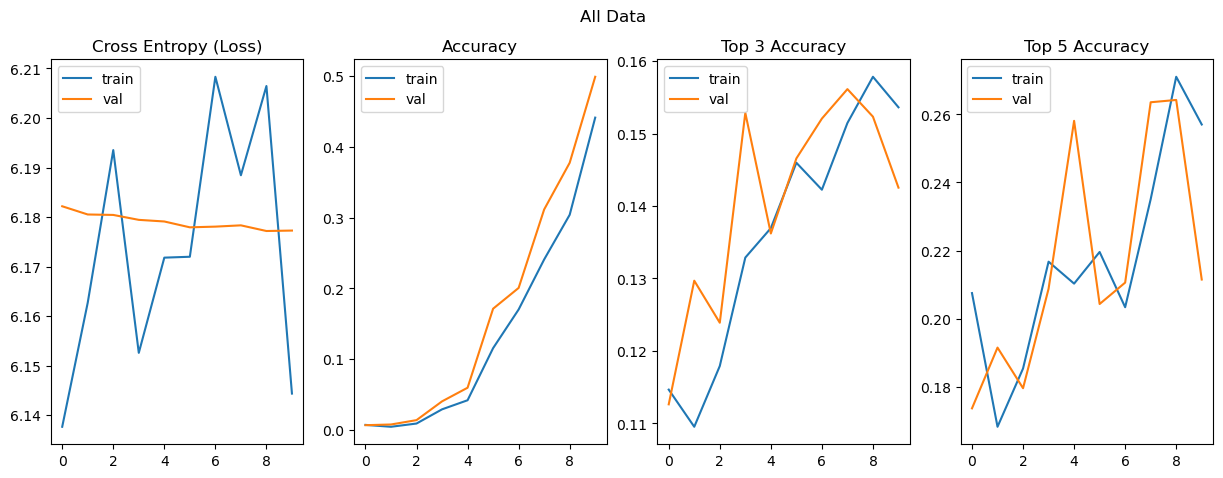

In [ ]:
f,ax=plt.subplots(1,4, figsize=(15, 5))
hist.loc[:, (slice(None), "loss")].droplevel(level=1,axis=1).plot(title="Cross Entropy (Loss)", ax=ax[0])
hist.loc[:, (slice(None), "acc")].droplevel(level=1,axis=1).plot(title="Accuracy", ax=ax[1])
hist.loc[:, (slice(None), "acc_top3")].droplevel(level=1,axis=1).plot(title="Top 3 Accuracy", ax=ax[2])
hist.loc[:, (slice(None), "acc_top5")].droplevel(level=1,axis=1).plot(title="Top 5 Accuracy", ax=ax[3])
f.suptitle("All Data")

In [ ]:
# Data through one model per reaction cluster
# rxn_diff_fp width -> ohe width

train_clusters = Kmean.predict(rxn_diff_fp_train)
val_clusters = Kmean.predict(rxn_diff_fp_val)

cluster_models = {}
cluster_histories = {}

for cluster in np.unique(train_clusters):
    x_train = torch.Tensor(rxn_diff_fp_train[train_clusters == cluster])
    y_train = torch.Tensor(reag1_ohe_train[train_clusters == cluster])
    x_val = torch.Tensor(rxn_diff_fp_val[val_clusters == cluster])
    y_val = torch.Tensor(reag1_ohe_val[val_clusters == cluster])
    fcrm = FullyConnectedReactionModel(
        input_dim=x_train.shape[1],
        hidden_dims=[600,600],
        target_dim=y_train.shape[1],
        hidden_act=torch.nn.ReLU, 
        output_act=torch.nn.Sigmoid, 
        use_batchnorm=True, 
        dropout_prob=0.1,
    )

    hist = train_loop(fcrm, x_train, y_train, epochs=500, batch_size=0.001, loss_fn=torch.nn.CrossEntropyLoss(), optimizer=torch.optim.Adam(fcrm.parameters(), lr=1e-2), report_freq=1, x_val=x_val, y_val=y_val)
    cluster_models[cluster] = fcrm
    cluster_histories[cluster] = hist

100%|██████████| 100/100 [00:07<00:00, 12.56it/s]


Epoch: 0 Train [ Loss: 6.22463 | Acc (Top 1): 0.10669 | Acc (Top 3): 0.25142 | Acc (Top 5): 0.34406]	 Validation [ Loss: 6.24225 | Acc (Top 1): 0.12292 | Acc (Top 3): 0.30039 | Acc (Top 5):  0.40324]


100%|██████████| 100/100 [00:08<00:00, 11.79it/s]


Epoch: 1 Train [ Loss: 6.25106 | Acc (Top 1): 0.08626 | Acc (Top 3): 0.26085 | Acc (Top 5): 0.39629]	 Validation [ Loss: 6.23493 | Acc (Top 1): 0.08405 | Acc (Top 3): 0.27275 | Acc (Top 5):  0.43989]


100%|██████████| 100/100 [00:01<00:00, 52.33it/s]


Epoch: 0 Train [ Loss: 6.24509 | Acc (Top 1): 0.22010 | Acc (Top 3): 0.54745 | Acc (Top 5): 0.69776]	 Validation [ Loss: 6.23855 | Acc (Top 1): 0.20190 | Acc (Top 3): 0.48821 | Acc (Top 5):  0.66818]


100%|██████████| 100/100 [00:01<00:00, 54.53it/s]


Epoch: 1 Train [ Loss: 6.21385 | Acc (Top 1): 0.10520 | Acc (Top 3): 0.39786 | Acc (Top 5): 0.63898]	 Validation [ Loss: 6.13070 | Acc (Top 1): 0.06620 | Acc (Top 3): 0.24204 | Acc (Top 5):  0.58875]


100%|██████████| 132/132 [00:01<00:00, 79.49it/s]


Epoch: 0 Train [ Loss: 6.60383 | Acc (Top 1): 0.16919 | Acc (Top 3): 0.45960 | Acc (Top 5): 0.65657]	 Validation [ Loss: 6.31946 | Acc (Top 1): 0.23810 | Acc (Top 3): 0.58095 | Acc (Top 5):  0.74286]


100%|██████████| 132/132 [00:01<00:00, 81.38it/s]


Epoch: 1 Train [ Loss: 6.08970 | Acc (Top 1): 0.14646 | Acc (Top 3): 0.53788 | Acc (Top 5): 0.81566]	 Validation [ Loss: 6.19505 | Acc (Top 1): 0.17143 | Acc (Top 3): 0.44762 | Acc (Top 5):  0.77143]


100%|██████████| 100/100 [00:01<00:00, 69.23it/s]


Epoch: 0 Train [ Loss: 6.10281 | Acc (Top 1): 0.40214 | Acc (Top 3): 0.70714 | Acc (Top 5): 0.76214]	 Validation [ Loss: 6.21778 | Acc (Top 1): 0.36883 | Acc (Top 3): 0.75325 | Acc (Top 5):  0.81558]


100%|██████████| 100/100 [00:01<00:00, 69.88it/s]


Epoch: 1 Train [ Loss: 6.09386 | Acc (Top 1): 0.23857 | Acc (Top 3): 0.67786 | Acc (Top 5): 0.85143]	 Validation [ Loss: 6.17220 | Acc (Top 1): 0.12468 | Acc (Top 3): 0.40519 | Acc (Top 5):  0.71429]


100%|██████████| 100/100 [00:04<00:00, 24.50it/s]


Epoch: 0 Train [ Loss: 6.25778 | Acc (Top 1): 0.15091 | Acc (Top 3): 0.36888 | Acc (Top 5): 0.48649]	 Validation [ Loss: 6.28146 | Acc (Top 1): 0.13438 | Acc (Top 3): 0.35554 | Acc (Top 5):  0.49478]


100%|██████████| 100/100 [00:04<00:00, 23.90it/s]


Epoch: 1 Train [ Loss: 6.15203 | Acc (Top 1): 0.12036 | Acc (Top 3): 0.31616 | Acc (Top 5): 0.46967]	 Validation [ Loss: 6.17507 | Acc (Top 1): 0.14210 | Acc (Top 3): 0.32838 | Acc (Top 5):  0.54153]


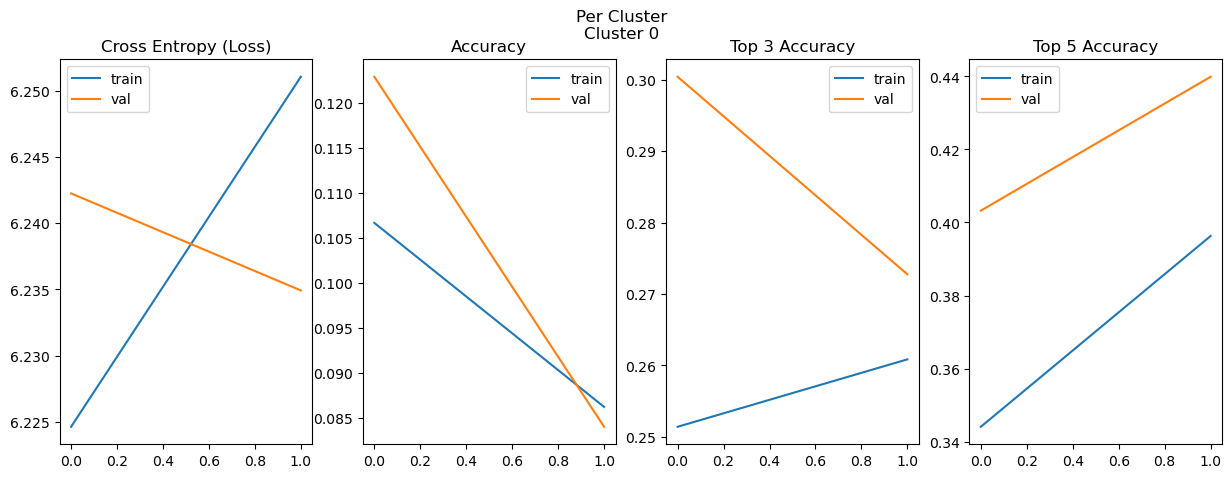

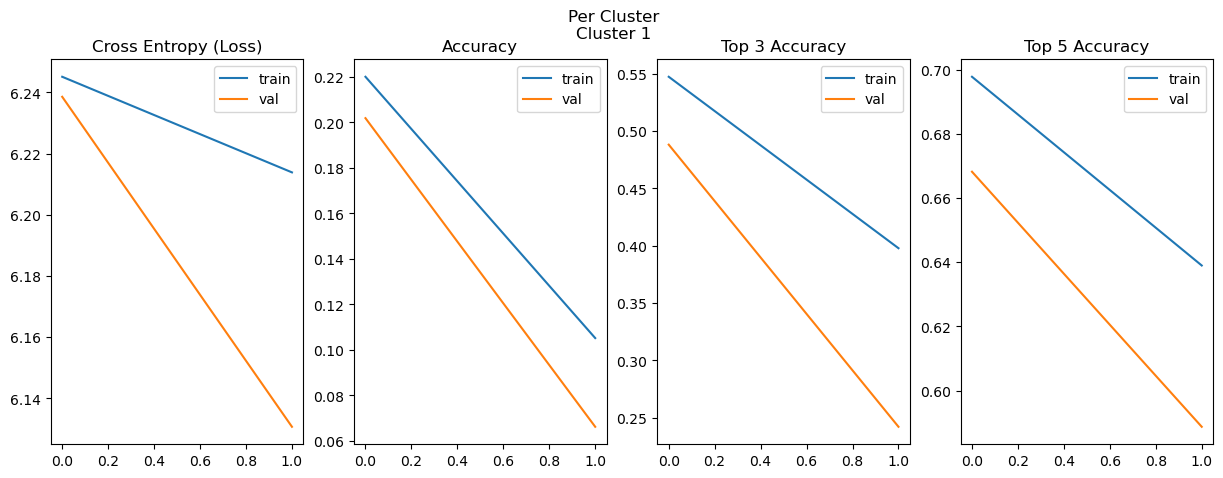

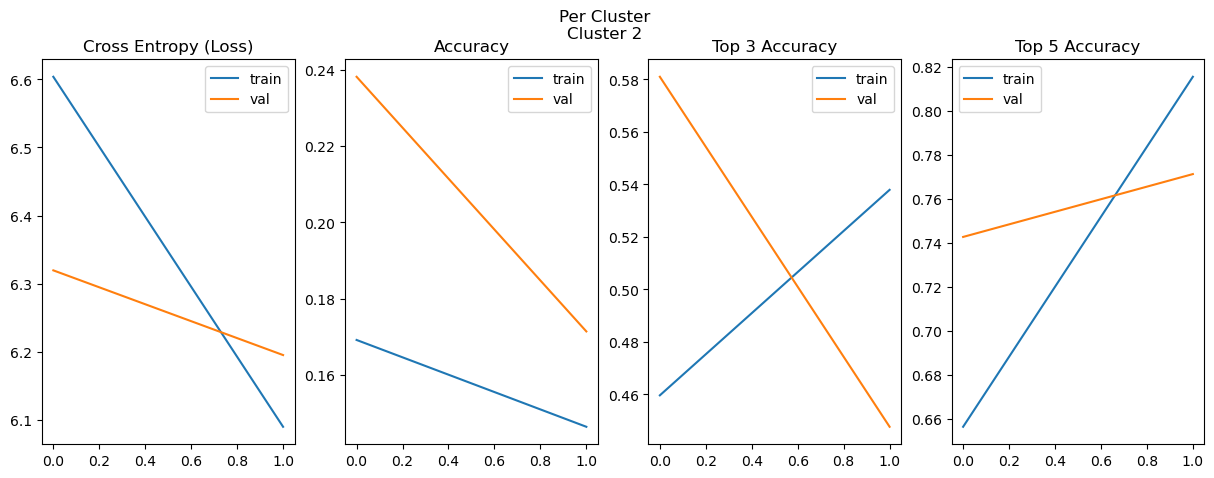

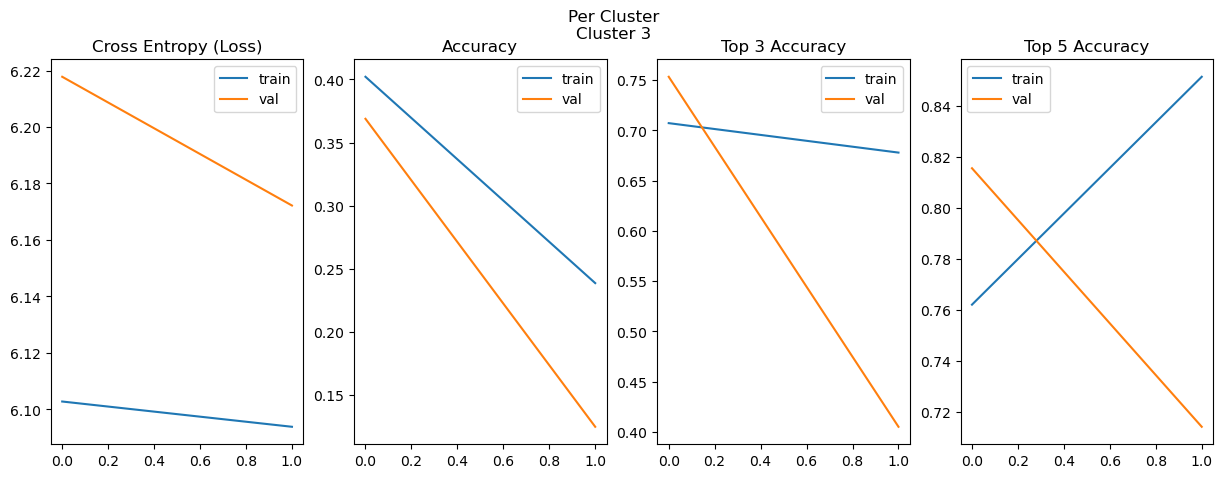

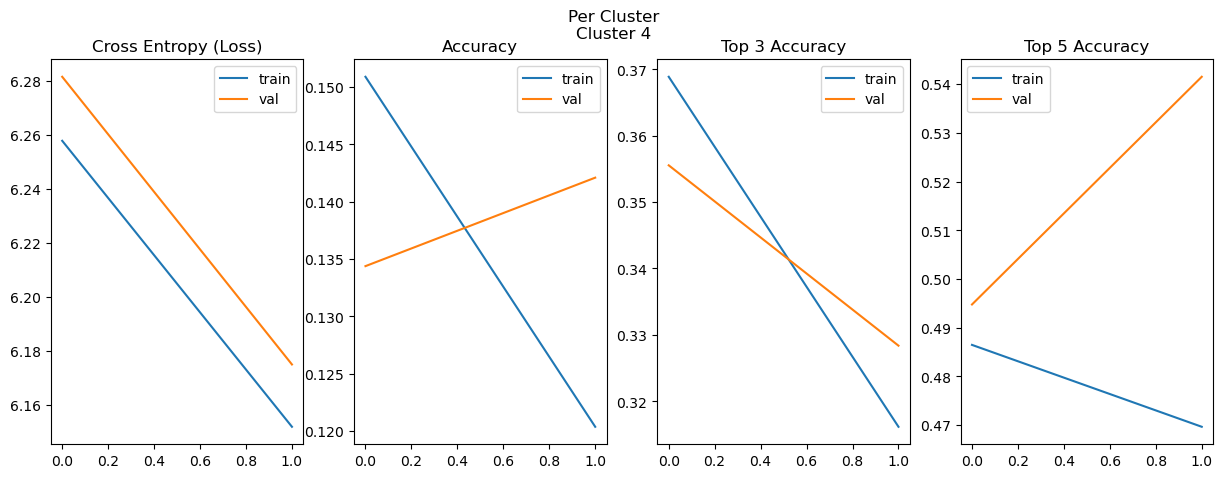

In [ ]:
for cluster in np.unique(train_clusters):   
    f,ax=plt.subplots(1,4, figsize=(15, 5))
    cluster_histories[cluster].loc[:, (slice(None), "loss")].droplevel(level=1,axis=1).plot(title=f"Cross Entropy (Loss)", ax=ax[0])
    cluster_histories[cluster].loc[:, (slice(None), "acc")].droplevel(level=1,axis=1).plot(title=f"Accuracy", ax=ax[1])
    cluster_histories[cluster].loc[:, (slice(None), "acc_top3")].droplevel(level=1,axis=1).plot(title=f"Top 3 Accuracy", ax=ax[2])
    cluster_histories[cluster].loc[:, (slice(None), "acc_top5")].droplevel(level=1,axis=1).plot(title=f"Top 5 Accuracy", ax=ax[3])
    f.suptitle(f"Per Cluster\nCluster {cluster}")
    plt.show()

In [79]:
# Shared upstream layers but then downstream they become cluster specific

# we can either have the model train the clusters at the same time or one after the other (in single epoch steps)
# TODO I am unsure how the gradient graph will be built if trained at the same time

class SharedUpstreamReactionModel(torch.nn.Module):

    def __init__(
        self, 
        *,
        num_clusters, 
        input_dim, 
        hidden_dims,
        target_dim, 
        hidden_act, 
        output_act, 
        use_batchnorm, 
        dropout_prob,
        downstream_input_dim,
        downstream_hidden_dims,
        downstream_hidden_act, 
        downstream_output_act, 
        downstream_use_batchnorm, 
        downstream_dropout_prob,
    ):
        super(SharedUpstreamReactionModel, self).__init__()

        self.target_dim = target_dim

        self.shared_upstream = FullyConnectedReactionModel(
            input_dim=input_dim,
            hidden_dims=hidden_dims,
            target_dim=downstream_input_dim,
            hidden_act=hidden_act, 
            output_act=output_act, 
            use_batchnorm=use_batchnorm, 
            dropout_prob=dropout_prob,
        )

        self.downstream_models = {}
        for c in range(num_clusters):
            self.downstream_models[c] = FullyConnectedReactionModel(
                input_dim=downstream_input_dim,
                hidden_dims=downstream_hidden_dims,
                target_dim=target_dim,
                hidden_act=downstream_hidden_act, 
                output_act=downstream_output_act, 
                use_batchnorm=downstream_use_batchnorm, 
                dropout_prob=downstream_dropout_prob,
            )

    def forward(self, x, cluster_ids, training=True):
        shared_output = self.shared_upstream(x, training=training)
        output = torch.zeros(shared_output.shape[0], self.target_dim)

        for c in np.unique(cluster_ids):
            cluster_model_output = self.downstream_models[c](shared_output[cluster_ids == c], training=training)
            output[cluster_ids == c] = cluster_model_output
        return output

In [80]:
train_clusters = Kmean.predict(rxn_diff_fp_train)
val_clusters = Kmean.predict(rxn_diff_fp_val)
x_train = torch.Tensor(rxn_diff_fp_train)
y_train = torch.Tensor(reag1_ohe_train)
x_val = torch.Tensor(rxn_diff_fp_val)
y_val = torch.Tensor(reag1_ohe_val)


surm = SharedUpstreamReactionModel(
    num_clusters=len(np.unique(train_clusters)), 
    input_dim=x_train.shape[1], 
    hidden_dims=[600,600],
    target_dim=y_train.shape[1], 
    hidden_act=torch.nn.ReLU, 
    output_act=torch.nn.ReLU, 
    use_batchnorm=True, 
    dropout_prob=0.1,
    downstream_input_dim=100,
    downstream_hidden_dims=[100,100],
    downstream_hidden_act=torch.nn.ReLU, 
    downstream_output_act=torch.nn.Sigmoid, 
    downstream_use_batchnorm=True, 
    downstream_dropout_prob=0.1,
)

hist = train_loop(surm, x_train, y_train, epochs=1000, batch_size=0.1, loss_fn=torch.nn.CrossEntropyLoss(), optimizer=torch.optim.Adam(surm.parameters(), lr=1e-2), report_freq=1, train_cluster_ids_for_downstream=train_clusters, x_val=x_val, y_val=y_val, val_cluster_ids_for_downstream=val_clusters)

100%|██████████| 10/10 [00:13<00:00,  1.36s/it]


Epoch: 0 Train [ Loss: 6.94391 | Acc (Top 1): 0.04564 | Acc (Top 3): 0.07885 | Acc (Top 5): 0.09835]	 Validation [ Loss: 7.01338 | Acc (Top 1): 0.06099 | Acc (Top 3): 0.10664 | Acc (Top 5):  0.13523]


100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


Epoch: 1 Train [ Loss: 6.91771 | Acc (Top 1): 0.09842 | Acc (Top 3): 0.15517 | Acc (Top 5): 0.18790]	 Validation [ Loss: 6.93611 | Acc (Top 1): 0.15942 | Acc (Top 3): 0.24108 | Acc (Top 5):  0.28237]


100%|██████████| 10/10 [00:12<00:00,  1.30s/it]


Epoch: 2 Train [ Loss: 6.89654 | Acc (Top 1): 0.13169 | Acc (Top 3): 0.19926 | Acc (Top 5): 0.23514]	 Validation [ Loss: 6.89375 | Acc (Top 1): 0.22244 | Acc (Top 3): 0.32079 | Acc (Top 5):  0.36098]


 60%|██████    | 6/10 [00:07<00:05,  1.31s/it]

Text(0.5, 0.98, 'Shared Upstream')

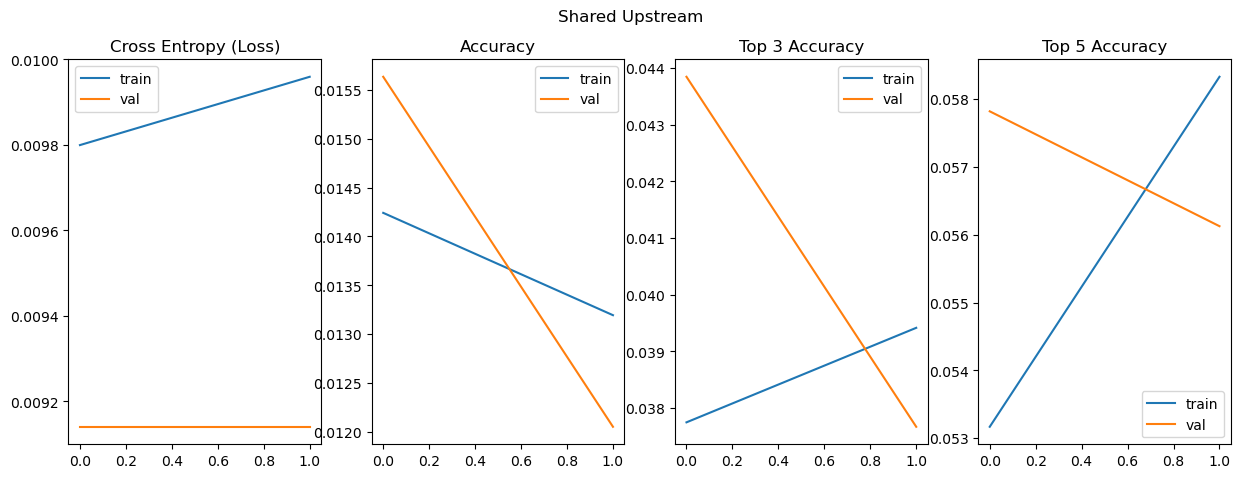

In [ ]:
f,ax=plt.subplots(1, 4, figsize=(15, 5))
hist.loc[:, (slice(None), "loss")].droplevel(level=1,axis=1).plot(title="Cross Entropy (Loss)", ax=ax[0])
hist.loc[:, (slice(None), "acc")].droplevel(level=1,axis=1).plot(title="Accuracy", ax=ax[1])
hist.loc[:, (slice(None), "acc_top3")].droplevel(level=1,axis=1).plot(title="Top 3 Accuracy", ax=ax[2])
hist.loc[:, (slice(None), "acc_top5")].droplevel(level=1,axis=1).plot(title="Top 5 Accuracy", ax=ax[3])
f.suptitle("Shared Upstream")

In [77]:
# Data through one model per reaction cluster but we scale the gradient based on the distance to the cluster, this is not parameter sharing but is infact a form of label smoothing

# rxn_diff_fp width -> ohe width
# we end up here with 10 valid models so we can either ensemble or just predict based on the which cluster is most near


In [ ]:
def similarity_CrossEntropyLoss(y_pred, y_true, dist):
    loss_fn = torch.nn.CrossEntropyLoss(reduction='none')
    return torch.mean(loss_fn(y_pred, y_true) * dist)

cluster_models = {}
cluster_histories = {}

x_train = torch.Tensor(rxn_diff_fp_train)
y_train = torch.Tensor(reag1_ohe_train)
x_val = torch.Tensor(rxn_diff_fp_val)
y_val = torch.Tensor(reag1_ohe_val)
train_dist = torch.nn.Softmax(dim=1)(torch.Tensor(Kmean.transform(rxn_diff_fp_train)))
val_dist = torch.nn.Softmax(dim=1)(torch.Tensor(Kmean.transform(rxn_diff_fp_val)))

for cluster in np.unique(train_clusters):
    fcrm = FullyConnectedReactionModel(
        input_dim=x_train.shape[1],
        hidden_dims=[600,600],
        target_dim=y_train.shape[1],
        hidden_act=torch.nn.ReLU, 
        output_act=torch.nn.Sigmoid, 
        use_batchnorm=True, 
        dropout_prob=0.1,
    )
    cluster_models[cluster] = fcrm

    hist = train_loop(fcrm, x_train, y_train, epochs=500, batch_size=0.01, loss_fn = similarity_CrossEntropyLoss, optimizer = torch.optim.Adam(fcrm.parameters(), lr=1e-2), report_freq=1, train_similarity_dist=train_dist[:, cluster], x_val=x_val, y_val=y_val, val_similarity_dist=val_dist[:, cluster])
    cluster_histories[cluster] = hist

100%|██████████| 100/100 [00:12<00:00,  7.86it/s]


Epoch: 0 Train [ Loss: 0.00001 | Acc (Top 1): 0.01183 | Acc (Top 3): 0.03365 | Acc (Top 5): 0.04640]	 Validation [ Loss: 0.00002 | Acc (Top 1): 0.01537 | Acc (Top 3): 0.04046 | Acc (Top 5):  0.05688]


100%|██████████| 100/100 [00:12<00:00,  7.76it/s]


Epoch: 1 Train [ Loss: 0.00001 | Acc (Top 1): 0.01287 | Acc (Top 3): 0.03721 | Acc (Top 5): 0.05097]	 Validation [ Loss: 0.00002 | Acc (Top 1): 0.01533 | Acc (Top 3): 0.04019 | Acc (Top 5):  0.05677]


100%|██████████| 100/100 [00:13<00:00,  7.47it/s]


Epoch: 0 Train [ Loss: 0.00333 | Acc (Top 1): 0.02516 | Acc (Top 3): 0.06525 | Acc (Top 5): 0.08301]	 Validation [ Loss: 0.00342 | Acc (Top 1): 0.02411 | Acc (Top 3): 0.05560 | Acc (Top 5):  0.08272]


 28%|██▊       | 28/100 [00:03<00:09,  7.41it/s]


KeyboardInterrupt: 

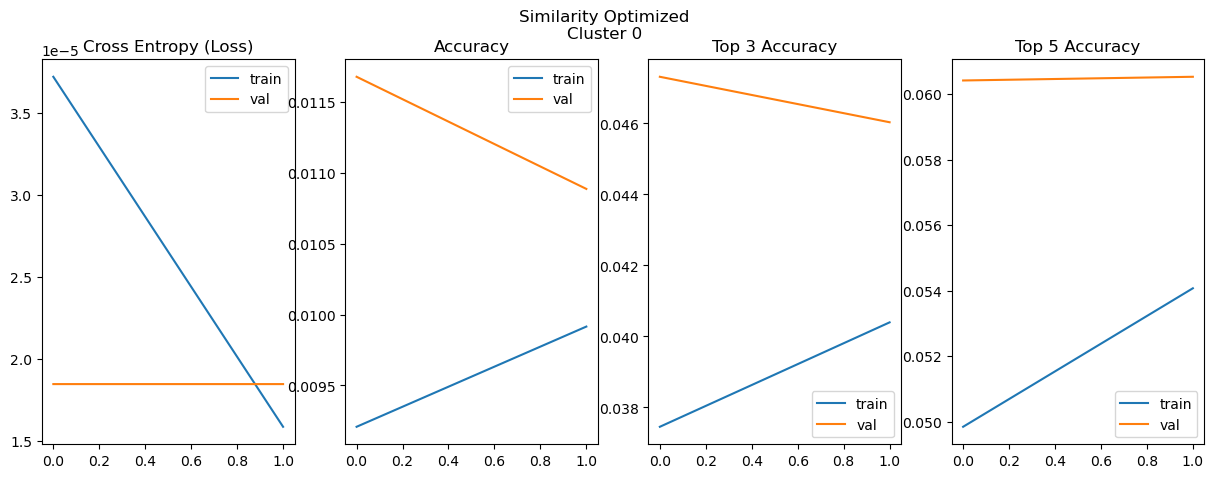

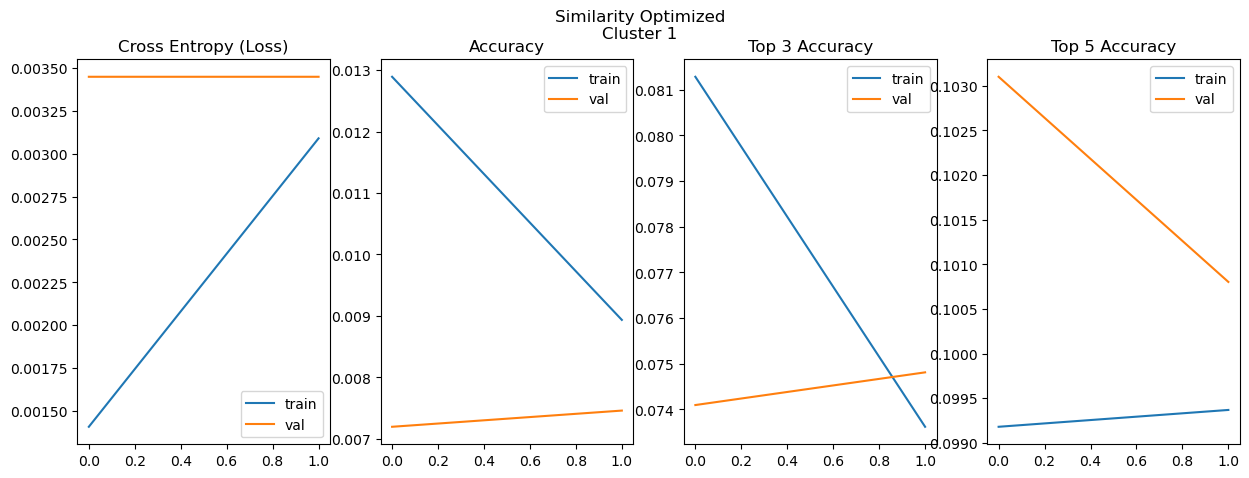

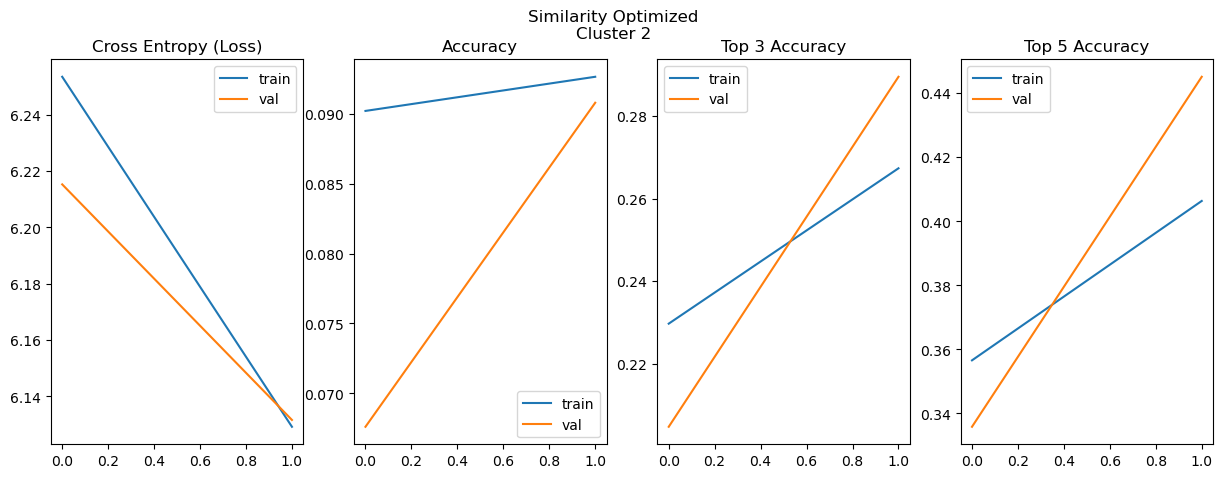

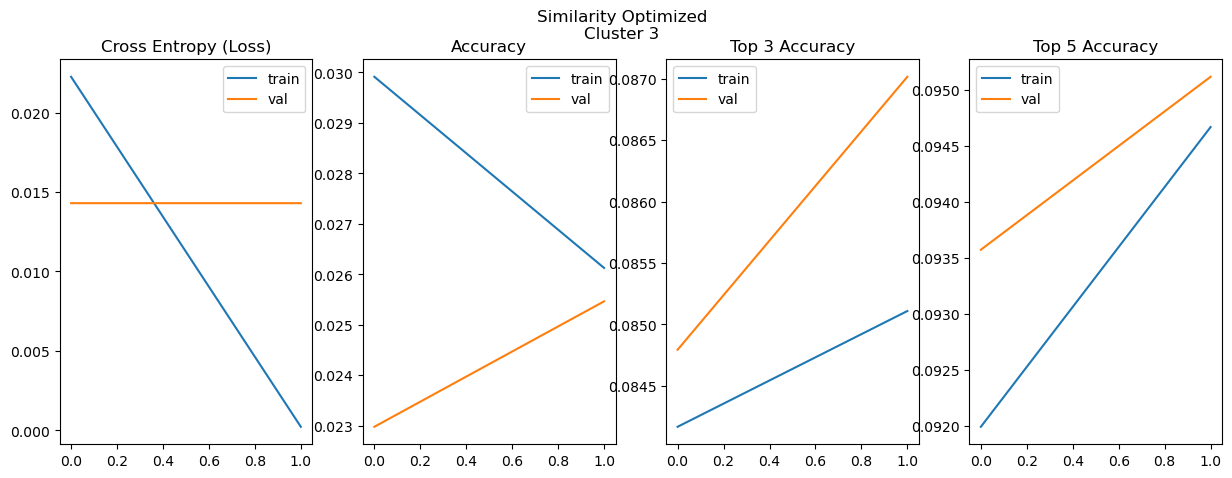

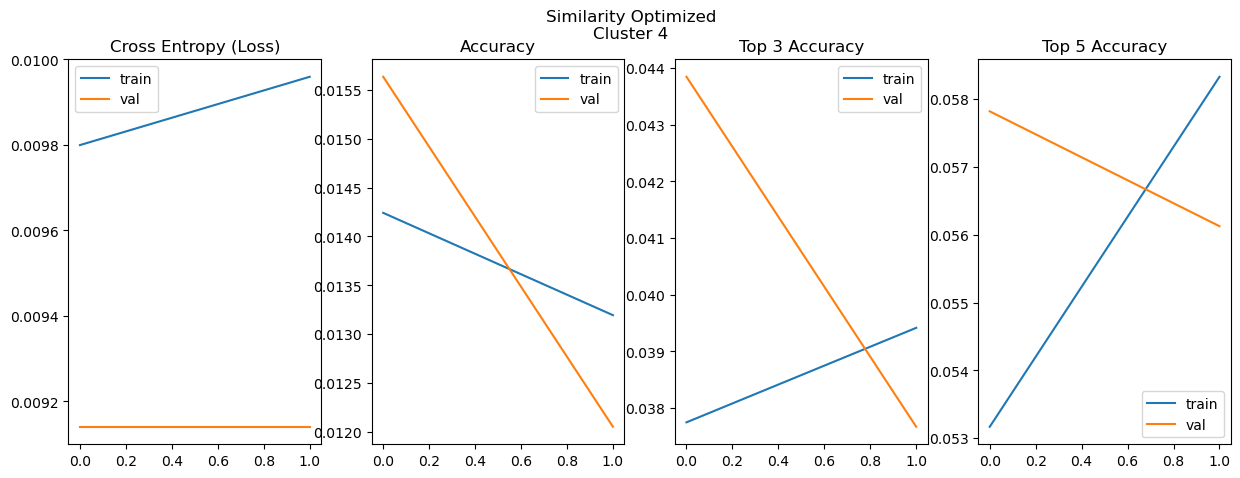

In [ ]:
for cluster in np.unique(train_clusters):   
    f,ax=plt.subplots(1, 4, figsize=(15, 5))
    cluster_histories[cluster].loc[:, (slice(None), "loss")].droplevel(level=1,axis=1).plot(title=f"Cross Entropy (Loss)", ax=ax[0])
    cluster_histories[cluster].loc[:, (slice(None), "acc")].droplevel(level=1,axis=1).plot(title=f"Accuracy", ax=ax[1])
    cluster_histories[cluster].loc[:, (slice(None), "acc_top3")].droplevel(level=1,axis=1).plot(title="Top 3 Accuracy", ax=ax[2])
    cluster_histories[cluster].loc[:, (slice(None), "acc_top5")].droplevel(level=1,axis=1).plot(title="Top 5 Accuracy", ax=ax[3])
    f.suptitle(f"Similarity Optimized\nCluster {cluster}")
    plt.show()